<!--# STAT 207: Data Science Exploration-->
## Hypothesis Testing

Many experiments and studies are designed to compare two or more sub-populations. 

**Example 1: Treatment versus control.** Patients randomized into two treatment versus a standard method of care represent two hypothetical population, one the population of potential patients if given the new treatment, and the other, the hypothetical population of potential patients given standard care.

**Example 2: A/B testing.** Visitors to a website are randomly presented one of two versions of the website in order to test out some new feature. Their subsequent navigation on the site is quantified and compared.  The populations are again hypothetical populations of potential visitors visiting the two versions of the website.

In both of the preceding examples, a randomized design was assumed. Subjects of the study are randomly assigned to receive one of two treatments or presentations. In this case any actual differences found can be attriubuted to the treatment because other effects have been randomized out so that on average they cancel. For such randomized studies are causal: they are able to establish that the treatment caused the effect. They are thus the gold standard in terms of comparing different groups in cases where such randomization is feasible and ethical. In many cases, however,  randomization is either impossible or unethical. 

**Example 3: Lead exposure study.** Children cannot ethically be assigned to low and high exposure to lead. However, those observed to have different levels may be studied in an observational fashion. The question still remains whether any differences detected could be purely due to chance or reflect a systematic association. 

Observational studies pose an additional challenge is the possibility of correlated deeper causes, called confounding effects, that cause both the differences in response and the differences in exposure. There are various advanced techiques to investigate and possible reduce the impact of potential confounding variables. We will investigate one of these, covariate adjustment, later in the context of multiple regression analysis.

**Example 4: Pew Survey Sub-Groups.** In the Pew opinion poll subjects were randomly selected, but the subgroups such as cell phone versus land line, or Republican versus Democrat are not assigned to them at random. Instead they fall into these groups as part of their overall personal profiles, e.g. self-determined. Such a poll is representative of the larger population due to random sampling, but the internal associations are not provably causal because they are not randomized into those groups.

Keeping these larger issues in mind, in this section, we focus on the basic issue of determining the statistical signficance of apparent effects observed in the data. 


We first discuss standard errors and confidence intervals for differences between group means and proportions. Then we develop the closely related hypothesis tests and their implementation. 

Specific testing ideas  are considered including:


+ Standard errors for two-sample difference statistics


+ Relation between confidence intervals and significance tests for differences between means and proportions


+ Formulating null and alternative hypotheses


+ p-values, $\alpha$ significance levels, and $1-\alpha$ confidence levels


+ Probabilities of false positives and false negatives: controlling the two types of errors


+ z-tests for proportions: direct calculation versus the statsmodels.stats proportions_ztest


+ t-tests for means: adjusting the normal approximation z-tests for smaller sample sizes




### Estimating group differences with standard errors and confidence intervals

Let's consider the situation where we want to compare the means or proportions between two population subgroups. We will take an independent random sample from each subgroup, here labeled Group A and Group B. Let $X_{gi}$ denote the quantitiative variable being measured for individual $i$ in group $g$. The resulting samples of random variables are:

$$
\begin{align}
\mbox{Group A:}&\qquad X_{11}, X_{12}, X_{13}, \ldots, X_{1n_1}\\
\\
\mbox{Group B:}&\qquad X_{21}, X_{22}, X_{23}, \ldots, X_{2n_2}\\
\end{align}
$$

In practice, data like this would often be organized in a data frame with one column corresponding to the quantitative variable $X$ and another column corresponding to the group variable. For example, in the lead exposure study the structure the data are organized as follows.


In [1]:
import pandas as pd
import numpy as np

In [2]:
# read csv file from parallel folder named 'data'
# import three specific variables from the csv file
df = pd.read_csv('../data/lead.csv')[['group', 'age', 'fulliq']]
# show first 4 and last 4 rows of the data frame
display(df.iloc[:4], df.iloc[df.shape[0]-4:df.shape[0]])

,group,age,fulliq
0,lead < 40,11.083333,70
1,lead < 40,9.416667,85
2,lead < 40,11.083333,86
3,lead < 40,6.916667,76


,group,age,fulliq
120,lead >= 40,4.583333,92
121,lead >= 40,5.166667,77
122,lead >= 40,3.833333,111
123,lead >= 40,3.916667,78


In the lead study, we can compare mean ages between the two exposure levels, to see if there is any age confounding. And we can compare 'fulliq' between groups to determine if there is a significant difference in cogntive assessment between the two groups.

#### Group difference between means

If the sample variables $X_{gi}$ are quantitative features for each individual, then we can compare the means between the two groups, estimating the mean difference. Notationally, here are the parameters and statistics of interest.

Group | Population Mean | Population  SD | Sample Mean | Sample SD | Standard error
--- | --- | --- | --- | --- | ---
A | $\mu_1$ | $\sigma_1$ | $\bar{X}_1$ | $S_1$ | $se_1 = \sqrt{S_1^2 \over n_1}$
B | $\mu_2$ | $\sigma_2$ | $\bar{X}_2$ | $S_2$ | $se_2 = \sqrt{S_2^2 \over n_2}$

If we are interested in drawing conclusions about the population mean difference, 

$$
\Delta = \mu_1 - \mu_2,
$$

we can use the estimator,

$$
\hat{\Delta} = \bar{X_1} - \bar{X_2}.
$$

What are the properties of this estimator? We know it is **unbiased** because

$$
E(\bar{X}_1 - \bar{X}_2) = E(\bar{X}_1) - E(\bar{X}_2) = \mu_1 - \mu_2
$$

**Standard error**

How about the precision of $\hat{\Delta}$ as an estimator, i.e., its population standard deviation? Because we have **independent** samples the two sample means are also independent. Therefore, using the general variance formula for linear combinations of random variables,

$$
\begin{align}
Var(\bar{X}_1 - \bar{X_2}) &= (1)^2\, Var(\bar{X}_1) + (-1)^2\, Var(\bar{X}_2) \\
\\
&= Var(\bar{X}_1) + Var(\bar{X}_2)\\
\\
&= {\sigma_1^2\over n_1} + {\sigma_2^2 \over n_2}\\
\end{align}
$$

$$
\implies SD(\bar{X}_1 - \bar{X_2}) = \sqrt{ {\sigma_1^2\over n_1} + {\sigma_2^2 \over n_2}}.
$$

Based on the previous results for single sample estimates, we can estimate the standard deviation for $\hat{\Delta}$ by the **standard error for the difference**: 

$$
SE(\hat{\Delta}) = \sqrt{se_1^2 + se_2^2} = \sqrt{{S_1^2\over n_1} + {S_2^2\over n_2}}.
$$

**Confidence interval**

As in the single sample design, the difference between sample means will be approximately normally distributed if the minimum of the two group sizes $n_1$ and $n_2$ is large enough. If so, then we get an approximate $100(1-\alpha)\%$ confidence interval of the form:

$$
\mu_1 - \mu_2 \in \left(\bar{X}_1 - \bar{X}_2\, \pm\, z_{1-{\alpha\over 2}} * \sqrt{{S_1^2\over n_1} + {S_2^2\over n_2}}\right)
$$

where $se_1$ and $se_2$ are given above. In other words, the margin of error for the difference is

$$
MOE = \pm z_{1-{\alpha\over 2}} \sqrt{\mbox{se}_1^2 + \mbox{se}_2^2}
$$

with a confidence level of $100(1-\alpha)\%$.

**Example: Mean age difference in the lead exposure study**. Let's compute a 95% confidence interval for the mean difference in ages between the low exposure group and the high exposure group.

In [3]:
df.head()

,group,age,fulliq
0,lead < 40,11.083333,70
1,lead < 40,9.416667,85
2,lead < 40,11.083333,86
3,lead < 40,6.916667,76
4,lead < 40,11.250000,84


In [4]:
# Extract the two subgroups from the data
age1 = df['age'][df['group']=='lead < 40']
age2 = df['age'][df['group']=='lead >= 40']

In [5]:
# compute sample means, standard deviations, n's
mn1, sd1, n1 = age1.mean(), age1.std(), age1.shape[0]
mn2, sd2, n2 = age2.mean(), age2.std(), age2.shape[0]

In [6]:
# compute single sample standard errors
se1, se2 = sd1/np.sqrt(n1), sd2/np.sqrt(n2)

In [7]:
# display summary stats
pd.DataFrame({'Group 1': [mn1, sd1, n1, se1],
             'Group 2': [mn2, sd2, n2, se2]},
             index= ['Mean', 'Std_Dev', 'n', 'Std_Err'])

,Group 1,Group 2
Mean,9.327991,8.269928
Std_Dev,3.572339,3.411952
n,78.000000,46.000000
Std_Err,0.404488,0.503065


In [8]:
from scipy.stats import norm

In [9]:
# mean difference and standard error
delta = mn1 - mn2
se_delta = np.sqrt(se1**2 + se2**2)

In [10]:
# MOE multiplier for 95% confidence
alpha = 0.05
zq = norm.ppf(1 - (alpha/2))

In [11]:
# display estimates and confidence interval
print('Mean difference:', round(delta, 4))
print('Std_Err:', round(se_delta, 4))
print('Confidence_level:', 1-alpha)
print('Confidence_Interval:', 
      (round(delta - zq*se_delta, 4), 
       round(delta+zq*se_delta, 4)))

Mean difference: 1.0581
Std_Err: 0.6455
Confidence_level: 0.95
Confidence_Interval: (-0.2071, 2.3232)


**Toward significance testing**

Did the confidence interval for the difference include the value 0? if so, we would conclude that, at a significance level of $\alpha=0.05$, there is not a significant difference between mean ages for the two groups. if the confidence interval does **not** include 0, then we conclude that there is a statistically significant difference in mean ages between the two groups.

**Example:** In the Lead Exposure study the 95% confidence interval for the difference between the mean age in the lower exposure group and the mean age in the higher exposure group included zero, so we conclude that the mean difference in ages is not statistically significant at the level $\alpha = 1-0.95 = 0.05$.

#### Group difference between proportions

The approach for proportions is parallel with that for means. The difference is in how we compute standard errors. If $X_{gi}$ are 0/1 Bernoulli values indicating presence or absence of some qualitative feature for each individual, then we can compare the proportions between the two groups. 

Group | Population proportion | Sample Proportion | Standard error
--- |--- | --- | ---
A | $p_1$ | $\hat{p}_1$ | $se_1$ $=$ $\sqrt{\hat{p_1}(1-\hat{p_1}) \over n_1}$
B | $p_2$ | $\hat{p}_2$ | $se_2$ $=$ $\sqrt{\hat{p_2}(1-\hat{p_2}) \over n_2}$

If we wish to compare proportions consider the sub-population difference:

$$
\Delta = p_1 - p_2.
$$

We have the unbiased estiamtor:

$$
\hat{\Delta} = \hat{p}_1 - \hat{p}_2.
$$

By the same reasoning as for the mean, the independence of the two samples implies

$$
SE(\hat{\Delta}) = \sqrt{\mbox{se}_1^2 + \mbox{se}_2^2}
$$

with the standard errors given in the table above. If the minimum sample size is large enough (i.e., all $n_g \hat{p}_g$ and $n_g(1-\hat{p}_g$ larger than around 5), then the difference in sample proportions is aproximately normally distributed. We therefore compute a $100(1-\alpha)\%$ confidence interval as

$$
p_1 - p_2 \in \left(\hat{p}_1 - \hat{p}_2 \,\pm\, z_{1-{\alpha\over 2}} * \sqrt{\mbox{se}_1^2 + \mbox{se}_2^2}\right).
$$

Just as we had in the case of general means, the margin of error for $100(1-\alpha)\%$ confidence has the form

$$
MOE = \pm z_{1-{\alpha\over 2}} \sqrt{\mbox{se}_1^2 + \mbox{se}_2^2}
$$


where we use the 'se' expressions for sample proportions.

### Example: Pew research survey party affiliation differences.

Previously we considered the February 2017 survey results for Question 1: "Do you approve or disapprove of the way Donald Trump is handling his job as President?" The possible answers were:

    1 Approve

    2 Disapprove

    9 Don't know/Refused (VOL.)

We found that the overall approval rate was $38.1\%$ with a margin of error of $\pm 2.45\%$.

Let's break out the results by self-identified party affiliation.

In [13]:
# include "Don't know/Refused (VOL.)" as a response - "Don't know" is a valid answer
dfpew = pd.read_csv('Feb17public.csv')
dfpew[['q1','party']].head(10)

,q1,party
0,Disapprove,Independent
1,Disapprove,Democrat
2,Disapprove,Independent
3,Approve,Republican
4,Disapprove,Democrat
5,Disapprove,Democrat
6,Disapprove,Independent
7,Approve,Republican
8,Approve,Independent
9,Disapprove,Independent


Here is how the results breakdown by party affiliation:

In [14]:
pd.crosstab(dfpew['party'], dfpew['q1'])

q1,Approve,Disapprove,Don't know/Refused (VOL.)
party,,,
Democrat,33,483,14
Don't know/Refused (VOL.),4,17,4
Independent,183,316,31
No preference (VOL.),15,18,8
Other party (VOL.),4,1,0
Republican,333,26,13


#### Democrats versus Republicans

We don't need fancy statistics to see that there was an enormous difference between Democrats and Republicans on this issue. Their respective rates of approval for President Trump's performance were:

In [15]:
# Extract q1 responses for democrats and republicans
dem = dfpew['q1'][dfpew['party']=='Democrat']
rep = dfpew['q1'][dfpew['party']=='Republican']

In [16]:
# calculate approval proportions
approv_dem = sum(dem=='Approve')/dem.shape[0] 
approv_rep = sum(rep=='Approve')/rep.shape[0]
disapp_dem = sum(dem=='Disapprove')/dem.shape[0] 
disapp_rep = sum(rep=='Disapprove')/rep.shape[0]

In [17]:
# display results
print('Democrats: Presidential approval rate =', round(approv_dem, 3),
     '  Disapproval rate =', round(disapp_dem, 3))
print('Republicans: Presidential approval rate =', round(approv_rep, 3),
     '  Disapproval rate =', round(disapp_rep, 3))

Democrats: Presidential approval rate = 0.062   Disapproval rate = 0.911
Republicans: Presidential approval rate = 0.895   Disapproval rate = 0.07


#### Independents versus "No preference"

A more subtle question is whether there is a significant difference between the presidential approval rates for Independents and the "No preference" category for party affiliation. We first compute the sample proportions and standard errors.

In [18]:
# extract q1 responses for independents and 'no preference'
indep = dfpew['q1'][dfpew['party']=='Independent']
nopref = dfpew['q1'][dfpew['party']=='No preference (VOL.)']

In [19]:
# calculate approval proportions
p_indep = sum(indep=='Approve')/indep.shape[0] 
p_nopref = sum(nopref=='Approve')/nopref.shape[0]

In [20]:
# calculate standard errors
se_indep = np.sqrt(p_indep*(1-p_indep)/indep.shape[0])
se_nopref = np.sqrt(p_nopref*(1-p_nopref)/nopref.shape[0])


In [21]:
# display estimates and standard errors into a data frame
pd.DataFrame({'indep': [p_indep, se_indep], 
              'nopref': [p_nopref, se_nopref]}, 
             index=['prop', 'std_err'])

,indep,nopref
prop,0.345283,0.365854
std_err,0.020653,0.075224


#### Significance test for the difference

Already we can see that the difference appears to be within the standard errors of the two proportions. To be rigorous, let's compute the difference and the standard error for the difference. We'll also display a 90% confidence interval.

In [22]:
# difference between proportions
p_diff = p_indep - p_nopref

In [23]:
# standard error for the difference
se_diff = np.sqrt(se_indep**2 + se_nopref**2)

In [24]:
# Compute MOE multiplier for 90% confidence level
conf = 0.90
zq = norm.ppf((1+conf)/2)

In [25]:
# Display summary incuding computed confidence interval
print("p_diff:", round(p_diff, 4))
print("se_diff:", round(se_diff, 4))
print('confidence_level:', conf, '  zq:', round(zq, 4))
print('confidence_interval:', (round(p_diff - zq*se_diff, 4), round(p_diff + zq*se_diff, 4)))

p_diff: -0.0206
se_diff: 0.078
confidence_level: 0.9   zq: 1.6449
confidence_interval: (-0.1489, 0.1077)


**Conclusion:** From the 90% confidence interval, which is almost centered on zero, we see that there is no statistically significant difference, at level $\alpha = 1-0.90 = 0.10$, between the presidential approval rates of self-identified Independents versus those with no party preference.

### Formulating hypotheses and testing them

As the previous examples show, we can use confidence intervals as way to decide if an apparent effect is "real" in the sense that it is statistically signficant with some level of confidence. More specifically, by comparing an estimated difference to its standard error we can determine whether the difference could be explained by chance alone, rather than by a systematic difference. If it cannot be explained by chance, then we conclude that a statistical signficant effect is detected.

#### z-test statistics

The confidence intervals in the examples above all shared the same basic structure:


+ Compute an estimate and its standard error;


+ If the estimate is a linear combination of averages, then it is approximately normal if the sample size(s) is(are) large. Use the standard normal distribution to determine the standard error multiplier, zq, for the margin of error with specified confidence level $1-\alpha$.


+ Compute a confidence interval of the form: $(\mbox{estimate} - z_q * \mbox{stderr},\,\,  \mbox{estimate} + z_q * \mbox{stderr})$.


+ If the confidence interval excludes a null value for the population parameter (e.g. difference = 0), then declare the effect statistically signficant at level $\alpha$. 


A confidence interval provides useful information because it gives both the estimated effect, and an uncertainty bound for that effect. For testing purposes though, it is possible to get to the conclusion more efficiently using a z-test statistic.



**General prescription for signficance tests.** Let's generically denote our population parameter of interest by $\theta$. This could be a population mean or proportion, or a difference between them. Denote our random sample estimate by $\hat{\theta}$. We'll assume $\hat{\theta}$ is approximately normally distributed by some application of the central limit theorem, and we can compute a standard error (estimated population standard deviation) for $\hat{\theta}$. Call it $se(\hat{\theta})$. 

Now let $\theta_0$ be a "null" value that indicates lack of any effect. The we have two equivalent ways to test for a statistically significant deviation from the null value $\theta_0$:


+ Method 1: Compute the $100(1-\alpha)%$ confidence interval, 
$(\hat\theta - z_{1-{\alpha\over 2}}*se(\hat\theta),\, \hat\theta + z_{1-{\alpha\over 2}}*se(\hat\theta))$. If $\theta_0$ is outside the confidence interval, then $\theta$ is statistical significantly different from $\theta_0$ at level $\alpha$.


+ Method 2: Compute the z statistic given in the equation below. If $\vert z\vert$ exceeds $z_{1-{\alpha\over 2}}$, then $\theta$ is statistically significantly different from $\theta_0$ at level $\alpha$.

$$
Z = {\hat{\theta} - \theta_0\over se(\hat{\theta})}
$$

Convince yourself that

$$
\theta_0 \in \left(\hat\theta - z_{1-{\alpha\over 2}}* se(\hat\theta),\quad 
\hat\theta + z_{1-{\alpha\over 2}}* se(\hat\theta)\right)\quad  
\iff \quad \left\vert {\hat\theta - \theta_0\over se(\hat\theta)}\right\vert\, \le \,z_{1-{\alpha\over 2}}
$$



**Examples:** 

1. In the lead exposure study, $\theta = \mu$, the population mean. A mean IQ measurement of $\mu_0=100$ for the exposed group would be considered a "null" effect because they would be showing normal development. We can test this null value using a z-test with
$$
Z = {\bar{X} - 100 \over S/\sqrt{n}}
$$

2. In the Pew Presidential approval survey, $\theta = p_1 - p_2$, the difference between subpopulatoin proportions. A difference in approval rates $\theta_0 = p_1-p_2=0$ is the null value. We can test this null value using a z-test with 
$$
Z = {\hat{p}_1 - \hat{p}_2 - 0   \over  se(\hat{p}_1 - \hat{p}_2)} =  {\hat{p}_1 - \hat{p}_2   \over  \sqrt{se_1^2 + se_2^2}}
$$


#### Null and alternative hypotheses

Often a scientific question can be set up as a hypothesis to be tested. The evidence is gathered through the sampling process and the data are analyzed. If the data are consistent with the hypothesis then it remains in consideration. If the data are inconsistent with the hypothesis it is rejected in favor of an alternative explanation or theory. 

The investigator might seek to establish that some systematic effect is present. By testing the negative, that the effect is absent, the investigator will seek to prove by contradiction that the effect is there. How does this work? Let's formulate hypotheses in terms of population parameters.

For the general discussion, let's call the population parameter $\theta$ for now. Again, this might be a population mean $\mu$ or a population proportion $p$, or a difference between means or proportions. In later sections we will see that this could be a coefficient in a regression model.

The null hypothesis, denoted $H_0$ is a statement about $\theta$ that represents either "no effect" or "status quo" or "normal population value". If $\theta_0$ is the "no effect" value of the parameter we write:

$$
H_0: \quad \theta=\theta_0.
$$

If this hypothesis is false, then the alternative is

$$
H_A: \quad \theta \ne \theta_0.
$$

If we have an estimate available for $\theta$ and it is approximately normally distributed, then we can compare its observed value to its distribution computed **assuming $H_0$ is true.** Thus we compare the deviation of the estimate from its expectation under the null hypothesis to its standard error by computing a z-value:

$$
\mbox{Z} = {\mbox{Estimate} - \mbox{Null expectation}  \over \mbox{Standard error} }.
$$

how do we judge how extreme this is? We can compute the probability of seeing a result this extreme if $H_0$ is true. That probability is the **p-value**. Using the normal approximation it has the form:

$$
\mbox{p_value} = P\left(\vert Z \vert > \vert z_{obs}\vert \right) = 2*P(Z < -\vert z_{obs} \vert)
$$

where $Z$ has a standard normal distribution, and $z_{obs}$ is the observed value of the Z statistic based on the data. This is called a two-tailed p-value because the calculation assumes both large positive and large negative deviations are of interest to detect. For computation, the probability can be calculated using the norm.cdf function in scipy.stats. 

**Is it statistically signficant?** If the p-value is very small that means the sticking with the null hypothesis requires us to believe a rare event has occurred. Therefore, very small values for the p value would lead us to reject $H_0$ in favor of $H_A$. In general, if the p value is smaller than $\alpha$, then the result is statistically significant (and we reject $H_0$) at level $\alpha$.



#### Graphical comparison of p-value and alpha level

The idea is illustrated in the graph below. The orange vertical lines indicate the cutoff values for an $\alpha$ level test. The shaded areas represent the tail probabilities that combine to give the p-value. By modifying the values for 'alpha' and 'zvalue' in the code we can see how the results change with different z values and different levels of significance.

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [27]:
# Set the target alpha significance level (1 - confidence level)
#
alpha = 0.05   # significance level
#
# Set hypothetical observed value for z-test statistic
#
zvalue = 1.6

In [28]:
# calculate p-value = two-tailed probability of 
# z-value this extreme assuming null hypothesis is true
#
pvalue = 2*norm.cdf(-abs(zvalue)) 
pvalue

0.10959858339911595

In [29]:
# grid for graphing the normal pdf
#
x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 100)

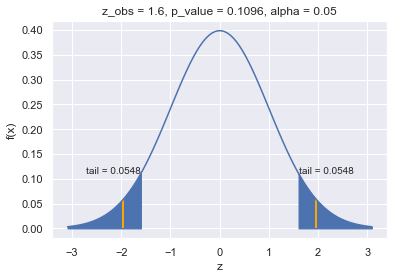

In [30]:
# pdf plot and axis labels
#
plt.plot(x, norm.pdf(x))
plt.xlabel('z')
plt.ylabel('f(x)')
#
# add dynamic title
#
plt.title('z_obs = ' + str(zvalue) + 
          ', p_value = ' + str(round(pvalue,4)) + ', alpha = ' + str(alpha))
#
# add dynamic text for tail probabilities
#
plt.text(-abs(zvalue), norm.pdf(-abs(zvalue)), 
         'tail = ' + str(round(pvalue/2, 4)), horizontalalignment='right')
plt.text(abs(zvalue), norm.pdf(abs(zvalue)), 
         'tail = ' + str(round(pvalue/2, 4)), horizontalalignment='left')
#
# add shaded areas whose probability we need
#
xzval1 = np.linspace(norm.ppf(0.001), -abs(zvalue), 100)
xzval2 = np.linspace(abs(zvalue), norm.ppf(0.999), 100)
plt.fill_between(xzval1, 0, norm.pdf(xzval1), color='b')
plt.fill_between(xzval2, 0, norm.pdf(xzval2), color='b')
#
# add vertical lines at z-alpha cutoffs
#
xcut = [norm.ppf(alpha/2), norm.ppf(1-(alpha/2))]
plt.vlines(x=xcut, ymin=0, ymax=norm.pdf(xcut), lw=2, colors='orange')
#
# show the graph
#
plt.show()

### Example: Difference in mean age for lower lead exposure group versus higher lead exposure group.

+ Population mean age for lower exposure group (lead < 40): $\mu_1$

+ Population mean age for higher exposure group (lead >= 40): $\mu_2$

+ Effect of interest: $\theta = \mu_1 - \mu_2$.

+ No effect hypothesis:  $H_0: \mu_1 - \mu_2 = 0$

+ Some effect hypothesis: $H_A: \mu_1 - \mu_2 \ne 0$.

The Z test statistic has the form:

$$
Z = {\bar{X}_1 - \bar{X_2} \over \sqrt{se_1^2 + se_2^2}}
$$

with $se_1 = S_1/\sqrt{n_1}$ and $se_2 = S_2/\sqrt{n_2}$. We previously computed a 95% confidence interval. Let's test the null hypothesis at a significance level of $\alpha=0.05$. We previously computed the difference in sample means ('delta') and its standard error ('se_delta') in order to get a confidence interval for the difference in means.


In [31]:
# compute z-value from mean difference and se for the difference
#
z_obs = delta/se_delta

In [32]:
# compute p-value from z-value
#
p_value = 2*norm.cdf(-abs(z_obs))

In [33]:
# summarize the test results
#
print('Null_Hypothesis: mu1 - mu2 = 0')
print('z_value = ', round(z_obs, 4))
print('p_value = ', round(p_value, 4))

Null_Hypothesis: mu1 - mu2 = 0
z_value =  1.6391
p_value =  0.1012


In this case the p-value is 0.1012 so we fail to reject $H_0$ at the $\alpha=0.05$ significance level.  Notice that the p-value is always the smallest $\alpha$ level at which the test would reject $H_0$. So, for example, this test *would* reject $H_0$ at the level $\alpha=0.20$, but a 1 in 5 chance is usually much larger than the burden of proof signficance levels in common use.

### Summary of normal approximation tests and confidence intervals

It is important to understand the components of the preceding development of confidence intervals and tests based on the normal apprimation for means and proportions. The essential components are 


+ The estimate of the effect or parameter of interest


+ The standard error for the estimate, and 


+ The desired confidence level or significance level. 


For a **confidence interval**,  we compute the lower and upper bounds for the populatoin parameter as:

$$(\mbox{estimate} \pm z_{q} * \mbox{standard error})$$

where $q = 1-{\alpha\over 2}$,  $z_q$ solves $P(-z_{q} \le Z \le z_{q}) = 1-\alpha$, and $Z$ represents a Normal(0,1) random variable.

To test hypotheses such as $H_0: \mu = \mu_0$, or $H_0: \mu_1 - \mu_2 = 0$ or $H_0: p_1 - p_2 = 0$  we compute a z-test statistic of the form

$$
z_{obs} = {\mbox{estimate} - \mbox{null expectation} \over \mbox{standard error}}
$$

To test against the two sided alternative with a significance level of $\alpha$ we can either


+ Compare $z_{obs}$ to $z_q$ with $q=1-{\alpha\over 2}$; reject $H_0$ if $\vert z_{obs} \vert > z_q$; or


+ Compute the p_value: pvalue = 2*norm.cdf(-abs(z_obs)); reject $H_0$ if p_value < $\alpha$.



### Probabilities of errors

What is the $\alpha$ level of a test? It may be helpful to think of this as the "false positive" rate for the test. Consider a test of the null hypothesis,

$$
H_0: \mu_1 - \mu_2 = 0,
$$

where the difference between the two groups is that group 1 received a promising new treatment, and group 2 received a placebo. Suppose $\mu$ represents mean time to cure, so a smaller value is better. Patients are randomized into the two groups and treatted accordgingly. At the end of the trial their times to cure are collected a two sample test statistic, z, is computed. The larger $\vert z \vert$ is the more evidence against the null hypothesis. If we set a cut off value of $z^*$, then we would

$$
\mbox{Reject } H_0 \mbox{ if  } \vert z \vert \gt z*
$$

and accept $H_0$ otherwise. What is the probability of falsely rejecting $H_0$ and declaring that the drug works? It is 

$$
\alpha = P(\vert Z \vert > z^* \vert\, H_0) 
$$

where the notation here means that the probability calculation is done assuming $H_0$ is correct. We see that the large we set $z^*$, the smaller the probability of declaring a false positive. 

Why not just make $z^*$ super large so we almost never make an error?

The problem is that the larger we make $z^*$, the harder it is to detect a real difference. We lose **power** to detect an effect of medical signficance. We would increase the **false negative** rate. Therefore we have to trade off these two goals, preventing false positives, and detecting true positives in setting our target significance levels. 

In general, for a given effect size and fixed false postive rate, the only way to increase the true detection rate is to increase the sample size, i.e., run a larger study. However, this comes at a greater cost. Therefore, the planning of large studies will usually require a **power analysis** to determine whether the proposed sample sizes are large enough to detect effect sizes of interest with a reasonable high probability. Power analysis is a topic for advanced courses and a standard component of many research grant proposals.

### Large sample Z-tests for proportions



For testing hypotheses about proportions, z-tests of the type described above are available in the statsmodels package. First, let's consider again the Pew Survey example and th edirect computatoins involved in performing the test.

**Example: Pew Research Survey Presidential Approval Comparison of independent and "no preference" party affiliation.**

+ Population approval proportion for independents: $p_1$

+ Population approval for "no party preference": $p_2$

+ Effect of interest: $\theta = p_1 - p_2$.

+ No effect hypothesis:  $H_0: p_1 - p_2 = 0$

+ Some effect hypothesis: $H_A: p_1 - p_2 \ne 0$.

The **two-sample** Z test statistic has the form:

$$
Z = {\hat{p}_1 - \hat{p_2} \over \sqrt{se_1^2 + se_2^2}}
$$

with $se_1 = \sqrt{\hat{p}(1-\hat{p}_1)/n_1}$ and $se_2 = \sqrt{\hat{p}_2(1-\hat{p}_2)/n_2}$

As we analyze the data we compute the observed value for $Z$, call it $z_{obs}$. The we compute the p-value = $P(\vert Z \vert > \vert z_{obs} \vert = 2 P(Z \lt -\vert z_{obs} \vert)$. If we have a target signficance level $\alpha$, then reject $H_0$ if p-value < $\alpha$ and fail to reject $H_0$ if p-value > $\alpha$.


**Direct calculations:** Let's do the calculations using a significance level of $\alpha=0.10$. We've already calcuated p_diff = $\hat{p}_1 - \hat{p}_2$ and se_diff = the standard error for the difference because we needed these previously in order to compute the $90\%$ confidence interval.

In [34]:
# extract subset data for independents and "no preference"
indep = dfpew['q1'][dfpew['party']=='Independent']
nopref = dfpew['q1'][dfpew['party']=='No preference (VOL.)']

In [35]:
# compute sample proportions and standard errors
p_indep = sum(indep=='Approve')/indep.shape[0] 
p_nopref = sum(nopref=='Approve')/nopref.shape[0]
se_indep = np.sqrt(p_indep*(1-p_indep)/indep.shape[0])
se_nopref = np.sqrt(p_nopref*(1-p_nopref)/nopref.shape[0])

In [36]:
# compute difference between sample proportions and 
# standard error for difference
p_diff = p_indep - p_nopref
se_diff = np.sqrt(se_indep**2 + se_nopref**2)

In [37]:
# confidence level = 1 - alpha level
conf = 0.90
# MOE multipler
zq = norm.ppf((1+conf)/2)

In [38]:
# z-test statistic and p-value
z_obs = p_diff/se_diff
p_value = 2*norm.cdf(-abs(z_obs))

In [39]:
# display estimates, standard errors, confidence interval
# and test results
print("p_diff:", round(p_diff, 4))
print("se_diff:", round(se_diff, 4))
print('confidence_level:', conf, '  zq:', round(zq, 4))
print('confidence_interval:', (round(p_diff - zq*se_diff, 4), round(p_diff + zq*se_diff, 4)))
print('')
print('Null_Hypothesis: p1 - p2 = 0')
print('z_value', round(z_obs, 4))
print('p_value', round(p_value, 4))

p_diff: -0.0206
se_diff: 0.078
confidence_level: 0.9   zq: 1.6449
confidence_interval: (-0.1489, 0.1077)

Null_Hypothesis: p1 - p2 = 0
z_value -0.2637
p_value 0.792


Based on these results we fail to reject $H_0$ at level $\alpha=0.10$. We could easily observe a difference of this magnitude purely by chance!

### statsmodels.stats proportions_ztest

The calculation above are of a standard type that we could use in many situations. That is strong motivation for bundling the caluclations together into a general purpose function. The **statsmodels** package has just such a function. 

To install statsmodels from the anaconda command line:

    conda install -c conda-forge statsmodels

In [40]:
from statsmodels.stats.proportion import proportions_ztest

In [41]:
#### Uncomment below for more information about the function:
#?proportions_ztest

In order to use this function we need to reformat our category counts and sample sizes as illustrated below.

In [42]:
# extract approval counts and sample sizes for independents and "no preference"
count = [sum(dfpew['q1'][dfpew['party']=='Independent']=='Approve'),
         sum(dfpew['q1'][dfpew['party']=='No preference (VOL.)']=='Approve')]
nobs = [dfpew['q1'][dfpew['party']=='Independent'].shape[0],
        dfpew['q1'][dfpew['party']=='No preference (VOL.)'].shape[0]]
print("count: "+str(count))
print("nobs: "+str(nobs))

count: [183, 15]
nobs: [530, 41]


In [43]:
z, p = proportions_ztest(count, nobs)
print("z_obs: "+str(z))
print("p_obs: "+str(p))

z_obs: -0.266629809915134
p_obs: 0.7897542012729419


The results differ in the third decimal place from our direct calculations, because 'proportions_ztest' uses a pooled null hypothesis estimate of the population proportion for computing the standard error. This amounts to setting $\hat{p}_{10} = \hat{p}_{20} = (Y_1 + Y_2) / (n_1 + n_2)$ in the standard error formula. This is valid under the null hypothesis.

We confirm this below:

In [44]:
n0 = indep.shape[0] + nopref.shape[0]
p0 = (sum(indep=='Approve') + sum(nopref=='Approve'))/n0
# compute difference between sample proportions and 
# pooled standard error for difference
p_diff = p_indep - p_nopref
se0_indep = np.sqrt(p0*(1-p0)/indep.shape[0])
se0_nopref = np.sqrt(p0*(1-p0)/nopref.shape[0])
se0_diff = np.sqrt(se0_indep**2 + se0_nopref**2)
z0_obs = p_diff/se0_diff
print("z_obs: "+str(z0_obs))

z_obs: -0.266629809915134


For our purposes, if we do direct calculations we will normally use the unpooled standard error, because it makes the test and confidence interval equivalent. For testing purposes, both methods are correct and approximately equal in large samples under the null hypothesis.

**Example: testing a single proportion.**

The statsmodels proportions_ztest has options for testing that a single proportion equals a specified value as well. For example, suppose we wished to test if a "coin" is fair. We simulate 50 tosses of the coin and get 20 heads. In this case we wish to test:

$$
H_0: p=0.5 \quad \mbox{against} \quad H_A: p\ne 0.5.
$$

We can do the calculations directly to get a z-test:

$$
z_{obs} = {20 - 25 \over \sqrt{50*(0.4)(0.6)}} = -1.44
$$


In [45]:
z=(20-25)/np.sqrt(50*(0.4)*(0.6))
p=2*norm.cdf(-abs(z))
print("z_obs:"+str(z)+", p_obs:"+ str(p))

z_obs:-1.4433756729740645, p_obs:0.14891467317876572


For comparison, using proportions_ztest we obtain:

In [46]:
zv, pv = proportions_ztest(count=20, nobs=50, value=0.5)
print("z_obs:"+str(zv)+", p_obs:"+ str(pv))

z_obs:-1.443375672974064, p_obs:0.14891467317876578


### t-tests for means and mean differences: adjusting for small sample sizes

When testing hypotheses about population means, it is more common to use a t-test than a z-test. In large samples ($n > 35$) these are nearly the same. In small samples the t-test makes a degrees-of-freedom adjustment using the so-called t distribution  that is exact if the observations come from a normal distribution, and approximately correct if the observations are not Gaussian.

Where does this come from? The original derivation was for a random sample, $X_1, X_2, \ldots, X_n$ from a **normal distribution** with unknown mean $\mu$ and standard deviation $\sigma$. Suppose we wished to test the null hypotheses

$$
H_0: \mu=\mu_0
$$

We compute the test statistic

$$
Z = {\bar{X} - \mu_0 \over {s/\sqrt{n}}}.
$$

Under $H_0$ this is approximately a standard normal random variable if $n$ is large, but what is its exact distribution? This was derived in the early 20th century by S. Gossett under the pseudonym, "student." We refer to the distribution he derived as student's t distribution with $n-1$ degrees of freedom. This is strictly correct only if the sample is from a normal distribution. The t distribution resembles the normal distribution except that it has heavier tails and less probability in the middle. As the degrees of freedom become large (sample get larger), the t distribution with n-1 degrees of freedom converges to the standard normal distribution.


In [47]:
from scipy.stats import t
from scipy.stats import ttest_ind

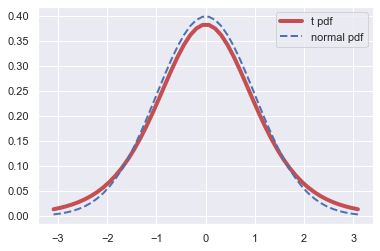

In [48]:
# set the degrees of freedom
df = 6
#
# grid for plotting the pdfs
#
x = np.linspace(norm.ppf(0.001), norm.ppf(0.999))
#
# plot the t pdf
#
plt.plot(x, t.pdf(x, df), 'r-', lw=4, label='t pdf')
#
# add the normal pdf
#
plt.plot(x, norm.pdf(x), 'b--', lw=2, label='normal pdf')
#
# label the curves
#
plt.legend()
#
# display the graph
#
plt.show()

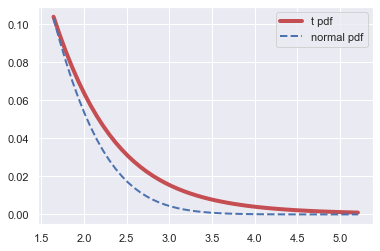

In [49]:
# Zoom in on one tail
xx = np.linspace(norm.ppf(0.95), t.ppf(0.999, df))
plt.plot(xx, t.pdf(xx, df), 'r-', lw=4, label='t pdf')
plt.plot(xx, norm.pdf(xx), 'b--', lw=2, label='normal pdf')
plt.legend()
plt.show()

For comparison of two independent samples the degrees of freedom calculation is more complicated unless we believe the two populations have the same standard deviations. Common practice currently is to avoid assuming equal standard deviations and use a more general approximate t-test attributed to Welch. Let's apply it to the Lead exposure study.

### Example: t-test for mean age difference in the lead exposure study.


In [50]:
# read csv file from 'data' folder
# import three specific variables from the csv file
#
dfage = pd.read_csv('../data/lead.csv')[['group', 'age']]
#
# extract ages for the two exposure groups
#
age1 = dfage['age'][dfage['group']=='lead < 40']
age2 = dfage['age'][dfage['group']=='lead >= 40']
#
# two sample t test
#
ttest_ind(age1, age2, equal_var=False)

Ttest_indResult(statistic=1.6391103626442254, pvalue=0.10439536085091142)

Previously, using the z test approach we computed the z-test statistic: 

In [51]:
diff = age1.mean() - age2.mean()
se_diff = np.sqrt((age1.std()**2/len(age1)) + (age2.std()**2/len(age2)))
z_obs = diff/se_diff
print('z_value', z_obs)
print('p_value', 2*norm.cdf(-abs(z_obs)))

z_value 1.6391103626442254
p_value 0.10119027727733729


We see that the **statistic** is exactly the same, subject to rounding error. The **p-values** we computed using the two methods are very close but not the same, because the ttest result replaces the normal approximation with the Welch t test approximation. The samples sizes were:

In [52]:
len(age1), len(age2)

(78, 46)

These are both large enough that the t distribution, which has degrees of freedom at least as large as the minimum sample size, is very close to the normal distribution.

For general practice the t test for means is recommended over the z-test for means, due to its improved accuracy in smaller normal samples. In large samples it will give results very close to teh z-test for the means.

#### Degrees of freedom for Welch two sample t test

The degrees of freedom for the one-sample test equal $n-1$. For the two-sample test using the Welch version, the degrees of freedom have a formula that adjusts for the amount of variation between the standard error estimates. Specifically (and you don't have to memorize this!),

$$
\mbox{Welch t-test degrees of freedom} = {\left( se_1^2 + se_2^2 \right )^2
\over {se_1^4 \over n_1-1} + {se_2^4 \over n_2-1}}
= {se_{diff}^4 \over {se_1^4 \over n_1-1} + {se_2^4 \over n_2-1}}
$$

where $se_1=s_1/\sqrt{n_1}$ and $se_2=s_2/\sqrt{n_2}$. Notice the extreme cases:

+ If $se_1 >> se_2$, then the degrees of freedom $\approx$ $n_1 - 1$
+ If $se_1 << se_2$, then the degrees of freedom $\approx$ $n_2 - 1$

### Modified function to return the Welch t-test, degrees of freedom and confidence interval

Although the statsmodels function ttest_ind is handy for testing purposes, we might wish to extract both the degrees of freedom and a confidence interval. Here's a specialized function to do that. Note that it returns the results in the form of a python **dictionary**, which is a list of labeled items.

In [53]:
def myttest_ind(dat1, dat2, value=0, conf=0.95):
    #
    # sample summary statistics
    #
    mn1, mn2 = np.mean(dat1), np.mean(dat2)
    n1, n2 = len(dat1), len(dat2)
    se1 = np.std(dat1, ddof=1)/np.sqrt(n1)
    se2 = np.std(dat2, ddof=1)/np.sqrt(n2)
    #
    # mean difference and standard error
    #
    diff = mn1 - mn2
    se_diff = np.sqrt(se1**2 + se2**2)
    #
    # Welch t test degrees of freedom
    #
    deg = se_diff**4 / ((se1**4/(n1-1)) + (se2**4/(n2-1)))
    #
    # test statistic, pvalue and t confidence interval
    #
    statistic = (diff - value)/se_diff
    tcut = t.ppf((1+conf)/2, deg)
    pvalue = 2*t.cdf(-abs(statistic), deg)
    interval = (diff - tcut*se_diff, diff + tcut*se_diff)
    #
    # return results as a dictionary
    #
    return {'statistic': statistic, 
            'pvalue': pvalue, 
            'df': deg, 
            'conf': conf, 
            'interval': interval}

In [54]:
results = myttest_ind(age1, age2, conf=0.95)
results

{'statistic': 1.6391103626442256,
 'pvalue': 0.10439536085091138,
 'df': 98.04406396190795,
 'conf': 0.95,
 'interval': (-0.22292463432966447, 2.3390524408262605)}

Because of the varying types in the returned value of the function, we formatted the results as a **dictionary**, which is a set of keys and values of the form:

    {'key1': value1, 'key2': value2, ....}
    
This allows us to include the confidence interval, which is a 'tuple', in the output.

We can extract elements of the dictionary with a dict['element'] call as in the following example:

In [55]:
# display decision based on alpha level and pvalue
alpha = 1 - results['conf']
if results['pvalue'] < alpha:
    print('reject null hypothesis')
else:
    print('accept null hypothesis')

accept null hypothesis


---
STAT 207, Douglas Simpson, University of Illinois at Urbana-Champaign